In [1]:
import warnings
warnings.filterwarnings('ignore')
# We import all our dependencies.
import numpy as np
import torch
import sys
sys.path.append('../../../')
from models.lvae import LadderVAE
from boilerplate import boilerplate
import lib.utils as utils
import training
from tifffile import imread
from matplotlib import pyplot as plt
from tqdm import tqdm
import wandb
import random
import tifffile as tiff
import glob

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [ ]:
path="/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/patches/"

In [ ]:
patch_size = 64
train_images = tiff.imread(path+"train_data.tif")
train_y = tiff.imread(path+"train_label.tif")
val_images = tiff.imread(path+"val_data.tif")
val_y = tiff.imread(path+"val_label.tif")
test_images = tiff.imread(path+"test_data.tif")
test_y = tiff.imread(path+"test_label.tif")

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(train_images[10000])
plt.subplot(1, 2, 2)
plt.imshow(train_y[10000])
plt.show()

In [ ]:
xlist = []
print(len(train_y))
for batch_idx in range(len(train_y)):
        xlist.append(int(train_y[batch_idx][31][31]))
print(set(xlist))

In [ ]:
import torch

In [ ]:
a = torch.tensor([0])

In [ ]:
b = torch.tensor([0])

In [ ]:
a == b

In [ ]:
model_name = "Contrastive_MAE"
directory_path = "/group/jug/Sheida/HDN models/19022024/background added to negative pair/" 

# Data-specific
gaussian_noise_std = None
noiseModel = None 
# Training-specific
batch_size=128
virtual_batch = 64
lr=3e-4
max_epochs = 500
steps_per_epoch=400
test_batch_size=100

# Model-specific
num_latents = 5
z_dims = [32]*int(num_latents)
blocks_per_layer = 5
mask_size = 4
batchnorm = True
free_bits = 0.0 # if KLD is less than 1 then the loss won't be calculated
contrastive_learning = True

In [ ]:
debug             = False #[True, False]
save_output       = True #[True, False]
project           = 'Contrastive_MAE'
img_shape = (64,64)

In [ ]:
train_loader, val_loader, test_loader, data_mean, data_std = boilerplate._make_datamanager(train_images,train_y,val_images,val_y,
                                                                                           test_images,batch_size,
                                                                                           test_batch_size)

model = LadderVAE(z_dims=z_dims,blocks_per_layer=blocks_per_layer,data_mean=data_mean,data_std=data_std,noiseModel=noiseModel,
                  device=device,batchnorm=batchnorm,free_bits=free_bits,img_shape=img_shape,contrastive_learning=contrastive_learning,mask_size=mask_size).cuda()

model.train() # Model set in training mode

In [ ]:
training.train_network(model=model,lr=lr,max_epochs=max_epochs,steps_per_epoch=steps_per_epoch,directory_path=directory_path,
                       train_loader=train_loader,val_loader=val_loader,test_loader=test_loader,
                       virtual_batch=virtual_batch,gaussian_noise_std=gaussian_noise_std,
                       model_name=model_name,val_loss_patience=30, debug=debug, save_output=save_output, project_name=project, batch_size=batch_size)

In [3]:
directory_path = "/group/jug/Sheida/HDN_models/27022024/Contrastive_False/model/"
model = torch.load(directory_path+"Contrastive_MAE_best_vae.net")
trainHist=np.load(directory_path+"train_loss.npy")
reconHist=np.load(directory_path+"train_reco_loss.npy")
klHist=np.load(directory_path+"train_kl_loss.npy")
clHist=np.load(directory_path+"train_cl_loss.npy")
valHist=np.load(directory_path+"val_loss.npy")

In [11]:
# directory_path0 = "/group/jug/Sheida/HDN_models/27022024/Contrastive_cosine/model/"
directory_path0 = "/home/sheida.rahnamai/GIT/HDN/examples/Pixel_Noise/Convallaria/Contrastive_cosine_opp/model/"
model0 = torch.load(directory_path0+"Contrastive_MAE_best_vae.net")
trainHist0=np.load(directory_path0+"train_loss.npy")
reconHist0=np.load(directory_path0+"train_reco_loss.npy")
klHist0=np.load(directory_path0+"train_kl_loss.npy")
clHist0=np.load(directory_path0+"train_cl_loss.npy")
valHist0=np.load(directory_path0+"val_loss.npy")

In [ ]:
directory_path1 = "/group/jug/Sheida/HDN_models/22022024/Trained_model_3/model/"
# directory_path1 = "/home/sheida.rahnamai/GIT/HDN/examples/Pixel_Noise/Convallaria/Finetuned/model/"
model1 = torch.load(directory_path1+"Contrastive_MAE_best_vae.net")
trainHist1=np.load(directory_path1+"train_loss.npy")
reconHist1=np.load(directory_path1+"train_reco_loss.npy")
klHist1=np.load(directory_path1+"train_kl_loss.npy")
clHist1=np.load(directory_path1+"train_cl_loss.npy")
valHist1=np.load(directory_path1+"val_loss.npy")

In [8]:
def get_normalized_tensor(img,model,device):
    '''
    Normalizes tensor with mean and std.
    Parameters
    ----------
    img: array
        Image.
    model: Hierarchical DivNoising model
    device: GPU device.
    '''
    test_images = torch.from_numpy(img.copy()).to(device)
    data_mean = model.data_mean
    data_std = model.data_std
    test_images = (test_images-data_mean)/data_std
    return test_images

In [7]:
import torch.nn.functional as F
def cos_similarity(z1, z2):
    z1 = torch.from_numpy(z1)
    z2 = torch.from_numpy(z2)
    return torch.mean(F.cosine_similarity(z1, z2, dim=-1))

In [8]:
def dis(z1, z2):
    return np.mean(np.sqrt(((z1-z2)**2).sum(axis=1)))

In [9]:
from torch.distributions.normal import Normal
from torch.distributions import kl_divergence
def kl_d(z1, z2):
    m1, logv1 = z1
    m2, logv2 = z2
    m1 = torch.from_numpy(m1)
    logv1 = torch.from_numpy(logv1)
    m2 = torch.from_numpy(m2)
    logv2 = torch.from_numpy(logv2)
    std1 = (logv1 / 2).exp()
    std2 = (logv2 / 2).exp()
    dis1 = Normal(m1, std1)
    dis2 = Normal(m2, std2)
    temp = kl_divergence(dis1, dis2)
    temp = torch.reshape(temp, (-1, 32))
    return torch.mean(temp)

In [6]:
def distance_other(model, z1, z2):
    output1 = np.zeros((160, 4, 4))
    output2 = np.zeros((160, 4, 4))
    model.mode_pred=True
    model.eval()
    model.to(device)
    # z1 = torch.from_numpy(z1)
    z1 = z1.to(device=device, dtype=torch.float)
    z1 = z1.reshape(1,1,patch_size,patch_size)
    # z2 = torch.from_numpy(z2)
    z2 = z2.to(device=device, dtype=torch.float)
    z2 = z2.reshape(1,1,patch_size,patch_size)
    with torch.no_grad():
            sample1 = model(z1, z1)
            mu1 = sample1['mu']
            output1[:32] = mu1[0][0].cpu().numpy()[:,14:18,14:18]
            output1[32:64] = mu1[1][0].cpu().numpy()[:,6:10,6:10]
            output1[64:96] = mu1[2][0].cpu().numpy()[:,2:6,2:6]
            output1[96:128] = mu1[3][0].cpu().numpy()
            output1[128:160] = mu1[4][0].cpu().numpy().repeat(2,axis=1).repeat(2,axis=2)
            output1 = output1.T.reshape(-1,160)
            sample2 = model(z2, z2)
            mu2 = sample2['mu']
            output2[:32] = mu2[0][0].cpu().numpy()[:,14:18,14:18]
            output2[32:64] = mu2[1][0].cpu().numpy()[:,6:10,6:10]
            output2[64:96] = mu2[2][0].cpu().numpy()[:,2:6,2:6]
            output2[96:128] = mu2[3][0].cpu().numpy()
            output2[128:160] = mu2[4][0].cpu().numpy().repeat(2,axis=1).repeat(2,axis=2)
            output2 = output2.T.reshape(-1,160)
            # return dis(output1, output2)
            return cos_similarity(output1, output2)
            

In [11]:
def distance_kl(model, z1, z2):
    output1 = np.zeros((160, 4, 4))
    logvar1 = np.zeros((160, 4, 4))
    output2 = np.zeros((160, 4, 4))
    logvar2 = np.zeros((160, 4, 4))
    model.mode_pred=True
    model.eval()
    model.to(device)
    # z1 = torch.from_numpy(z1)
    z1 = z1.to(device=device, dtype=torch.float)
    z1 = z1.reshape(1,1,patch_size,patch_size)
    # z2 = torch.from_numpy(z2)
    z2 = z2.to(device=device, dtype=torch.float)
    z2 = z2.reshape(1,1,patch_size,patch_size)
    with torch.no_grad():
            sample1 = model(z1, z1)
            mu1 = sample1['mu']
            logvar = sample1['logvar']
            logvar1[:32] = logvar[0][0].cpu().numpy()[:,14:18,14:18]
            logvar1[32:64] = logvar[1][0].cpu().numpy()[:,6:10,6:10]
            logvar1[64:96] = logvar[2][0].cpu().numpy()[:,2:6,2:6]
            logvar1[96:128] = logvar[3][0].cpu().numpy()
            logvar1[128:160] = logvar[4][0].cpu().numpy().repeat(2,axis=1).repeat(2,axis=2)

            output1[:32] = mu1[0][0].cpu().numpy()[:,14:18,14:18]
            output1[32:64] = mu1[1][0].cpu().numpy()[:,6:10,6:10]
            output1[64:96] = mu1[2][0].cpu().numpy()[:,2:6,2:6]
            output1[96:128] = mu1[3][0].cpu().numpy()
            output1[128:160] = mu1[4][0].cpu().numpy().repeat(2,axis=1).repeat(2,axis=2)
            output1 = output1.T.reshape(-1,160)
            logvar1 = logvar1.T.reshape(-1,160)
            sample2 = model(z2, z2)
            mu2 = sample2['mu']
            logvar = sample2['logvar']
            logvar2[:32] = logvar[0][0].cpu().numpy()[:,14:18,14:18]
            logvar2[32:64] = logvar[1][0].cpu().numpy()[:,6:10,6:10]
            logvar2[64:96] = logvar[2][0].cpu().numpy()[:,2:6,2:6]
            logvar2[96:128] = logvar[3][0].cpu().numpy()
            logvar2[128:160] = logvar[4][0].cpu().numpy().repeat(2,axis=1).repeat(2,axis=2)

            output2[:32] = mu2[0][0].cpu().numpy()[:,14:18,14:18]
            output2[32:64] = mu2[1][0].cpu().numpy()[:,6:10,6:10]
            output2[64:96] = mu2[2][0].cpu().numpy()[:,2:6,2:6]
            output2[96:128] = mu2[3][0].cpu().numpy()
            output2[128:160] = mu2[4][0].cpu().numpy().repeat(2,axis=1).repeat(2,axis=2)
            output2 = output2.T.reshape(-1,160)
            logvar2 = logvar2.T.reshape(-1,160)
            return kl_d([output1,logvar1], [output2,logvar2])
            

In [13]:
patch_size = 64
centre_size = 4
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
golgis = imread("/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/patches/golgi/*.tif")
golgis = get_normalized_tensor(golgis, model, device)
golgi_hist = []
golgi_hist0 = []
# golgi_hist1 = []
num_golgi = len(golgis)
for i in tqdm(range(int(num_golgi/2))):
    # golgi_hist.append(distance_other(model,golgis[i],golgis[num_golgi-i-1]))
    golgi_hist.append(distance_other(model,golgis[i],golgis[num_golgi-i-1]))

    golgi_hist0.append(distance_other(model0,golgis[i],golgis[num_golgi-i-1]))
    # golgi_hist1.append(distance(model1,golgis[i],golgis[num_golgi-i-1]))

100%|██████████| 369/369 [01:08<00:00,  5.36it/s]


In [15]:
patch_size = 64
centre_size = 4
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
golgis = imread("/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/patches/golgi/*.tif")[:400,:,:]
mito = imread("/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/patches/mitochondria/*.tif")[:400,:,:]
# gra = imread("/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/patches/granules/*.tif")#[:400,:,:]
golgis = get_normalized_tensor(golgis, model, device)
mito = get_normalized_tensor(mito, model, device)
# gra = get_normalized_tensor(gra, model, device)

golgi_hist = []
golgi_hist0 = []
golgi_hist1 = []
num_golgi = len(golgis)
for i in tqdm(range(num_golgi)):
# for i in tqdm(range(int(num_golgi/2))):
    # golgi_hist.append(distance_other(model,golgis[i],mito[i]))
    golgi_hist.append(distance_other(model,golgis[i],golgis[num_golgi-i-1]))
    golgi_hist0.append(distance_other(model,golgis[i],mito[i]))
    # golgi_hist1.append(distance_other(model,golgis[i],gra[i]))
    # golgi_hist0.append(distance_other(model,golgis[i],mito[i]))
    # golgi_hist1.append(distance_other(model,golgis[i],gra[i]))


100%|██████████| 400/400 [01:01<00:00,  6.46it/s]


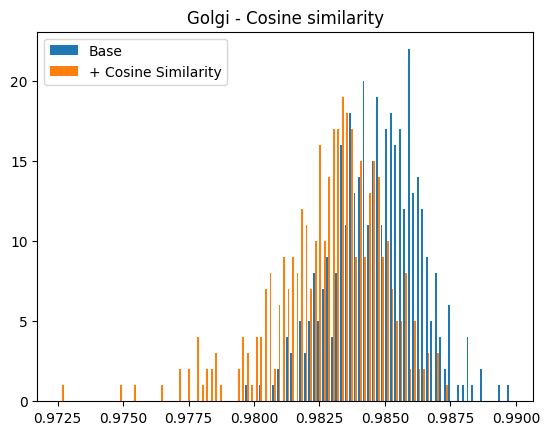

In [16]:
data = [golgi_hist, golgi_hist0]
plt.hist(data, bins=100, label=['Base', '+ Cosine Similarity'])
plt.title("Golgi - Cosine similarity")
plt.legend()
plt.show()

In [ ]:
n_bins = 100
fig, axs = plt.subplots(1, 1, sharey=False, tight_layout=False)
plt.title("Golgi <> Mitochondria - KLD")
axs.hist(golgi_hist, bins=n_bins)

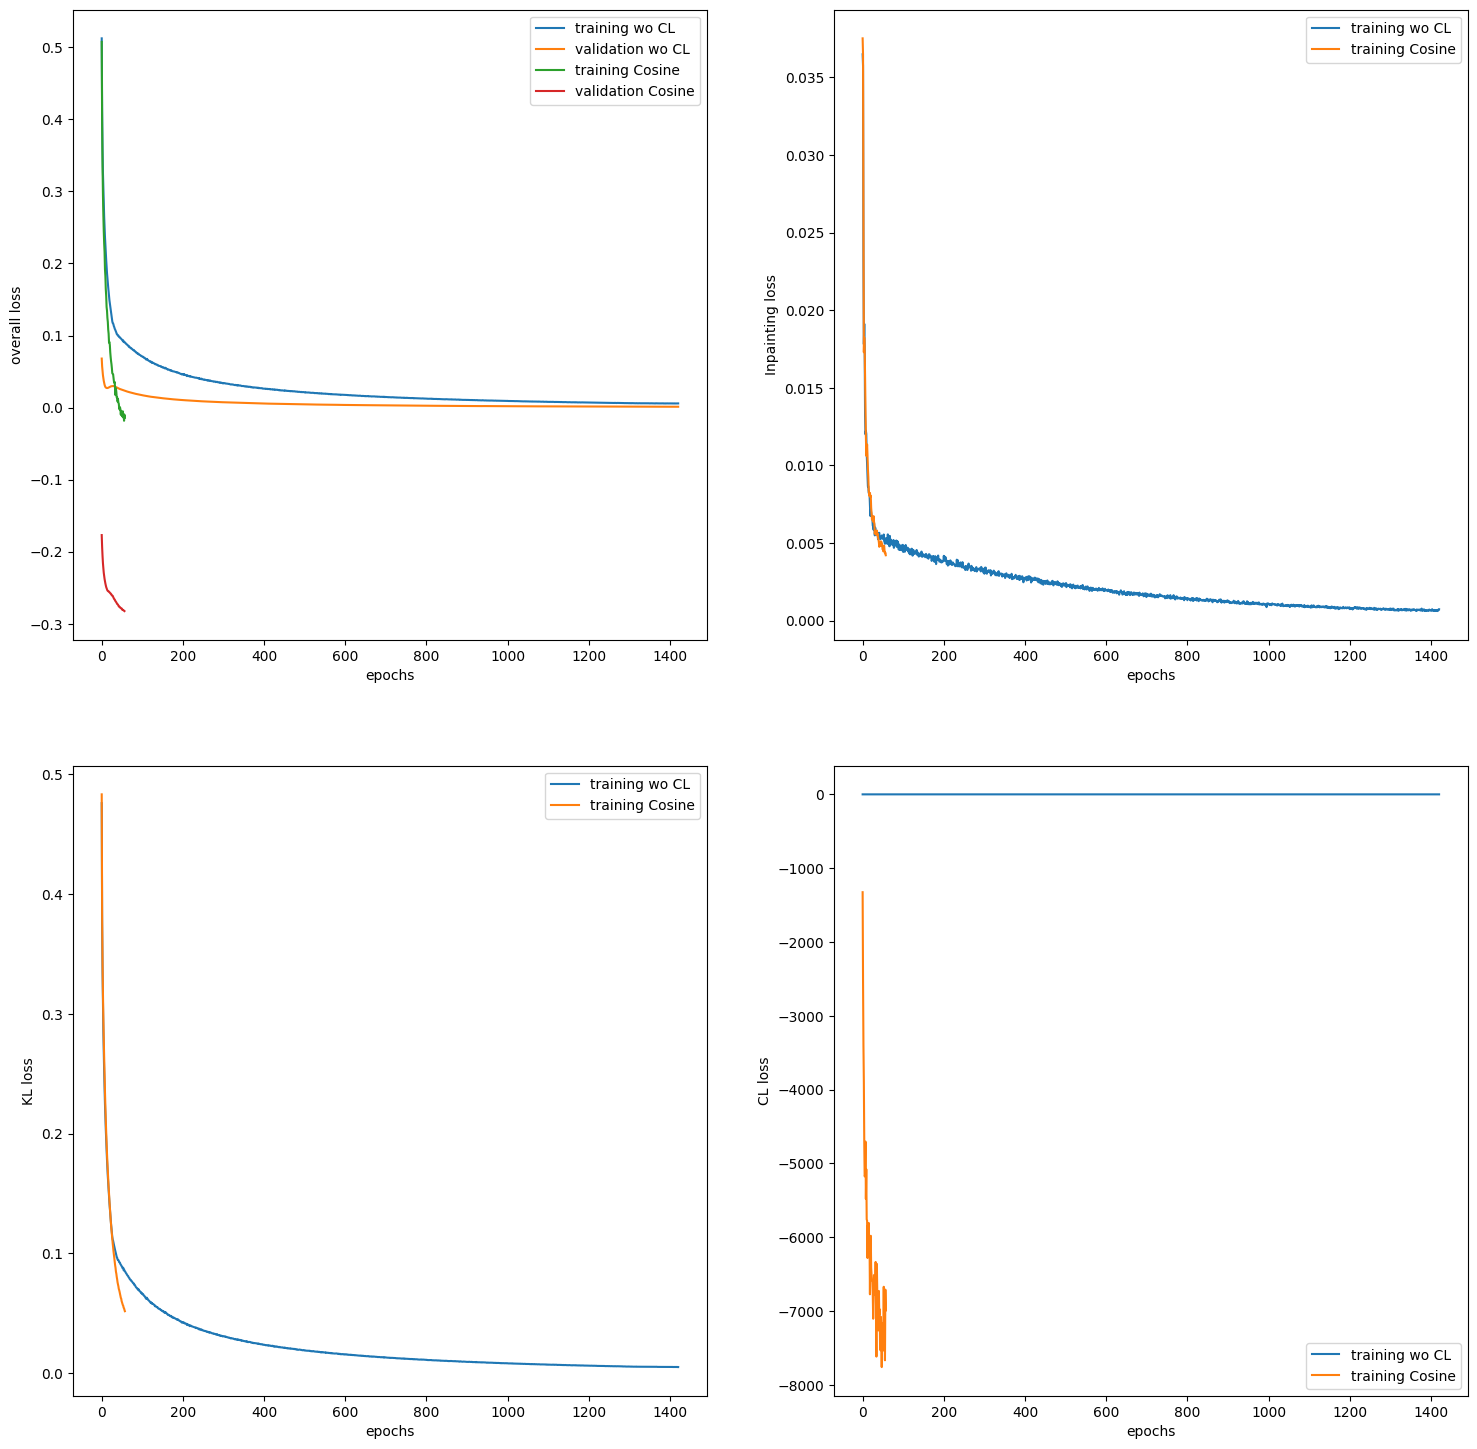

In [12]:
plt.figure(figsize=(18, 18))
plt.subplot(2,2,1)
plt.plot(trainHist,label='training wo CL')
plt.plot(valHist,label='validation wo CL')

plt.plot(trainHist0,label='training Cosine')
plt.plot(valHist0,label='validation Cosine')

plt.xlabel("epochs")
plt.ylabel("overall loss")
plt.legend()

plt.subplot(2,2,2)
plt.plot(reconHist,label='training wo CL')

plt.plot(reconHist0,label='training Cosine')

plt.xlabel("epochs")
plt.ylabel("Inpainting loss")
plt.legend()

plt.subplot(2,2,3)
plt.plot(klHist,label='training wo CL')

plt.plot(klHist0,label='training Cosine')

plt.xlabel("epochs")
plt.ylabel("KL loss")
plt.legend()

plt.subplot(2,2,4)
plt.plot(clHist,label='training wo CL')

plt.plot(clHist0,label='training Cosine')

plt.xlabel("epochs")
plt.ylabel("CL loss")
plt.legend()
plt.show()